In [1]:
import numpy as np
import tensorflow as tf
import json
import os
import sys
import pandas as pd
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load parameters
PARAMETERS_FILE = '/home/hhughes/Documents/Master_Thesis/Project/workspace/scripts/Parameters/model_params/local/ResNet50V2_test_local.json'

In [3]:
# Load parameters
with open(PARAMETERS_FILE, 'r') as file:
    p = json.load(file)
p.keys()

dict_keys(['_comment', 'model_path', 'external_libs_path', 'pp_path', 'local_tf_datasets', 'tf_ds_name', 'shuffle_files', 'random_horizontal_flipping', 'random_90deg_rotations', 'log_file_name', 'log_level', 'disable_gpu', 'set_memory_growth', 'model_name', 'number_of_epochs', 'loss', 'BATCH_SIZE', 'seed', 'input_channels'])

In [4]:
# Load external libraries path
EXTERNAL_LIBS_PATH = p['external_libs_path']
if not os.path.exists(EXTERNAL_LIBS_PATH):
    msg = 'External library path {} does not exist!'.format(EXTERNAL_LIBS_PATH)
    raise Exception(msg)
else:
    msg='EXTERNAL_LIBS_PATH: {}'.format(EXTERNAL_LIBS_PATH)
    print(msg)
# Add EXTERNAL_LIBS_PATH to sys paths (for loading libraries)
sys.path.insert(1, EXTERNAL_LIBS_PATH)
#import MPP_images

EXTERNAL_LIBS_PATH: /home/hhughes/Documents/Master_Thesis/Project/workspace/libs


In [5]:
# Make tf to ignore GPU
if p['disable_gpu']:
    msg = "Cuda devices (GPUs) disabled"
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
physical_devices = tf.config.experimental.list_physical_devices('GPU')
msg = 'Physical GPU devises:\n{}'.format(physical_devices)
print(msg)

#restrict GPU mem
if p['set_memory_growth']:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        msg = 'GPU Memory limited!'
    except:
        msg = 'It was not possible to limit GPU memory'   
    print(msg)

Physical GPU devises:
[]
It was not possible to limit GPU memory


## Load Preprocessing parameters and information:

In [6]:
# Preprocessed data path
pp_path = p['pp_path']

with open(os.path.join(pp_path, 'params.json')) as pp_file:
    pp_params = json.load(pp_file)
msg = 'Loaded data preprocessing parameters from:\n{}'.format(pp_file)
seed = pp_params['seed']

# Load Channels file
with open(os.path.join(pp_path, 'channels.csv')) as channel_file:
    channels = pd.read_csv(channel_file)
msg = 'Loaded channels file from:\n{}'.format(channel_file)

## Specify input channels

In [7]:
selected_channels = p['input_channels']
msg = 'Selected input channels:\n{}'.format(selected_channels)
print(msg)
# Get selected channel ids
input_ids = np.array(channels.set_index(['name']).loc[selected_channels].channel_id.values)
msg = 'Corresponding input channel ids:\n{}'.format(input_ids)
print(msg)

Selected input channels:
['01_CDK9_pT186', '05_Sm', '10_POL2RA_pS2']
Corresponding input channel ids:
[ 2 22 25]


## Load Dataset

In [8]:
# Path where tf datasets are
dataset, metadata = tfds.load(
    name=p['tf_ds_name'], 
    data_dir=p['local_tf_datasets'], 
    # If False, returns a dictionary with all the features
    as_supervised=True, 
    shuffle_files=False,
    with_info=True)
msg = 'Tensorflow dataset {} loaded from:\n{}'.format(p['tf_ds_name'], p['local_tf_datasets'])

# Load the splits
train_data, val_data, test_data = dataset['train'], dataset['validation'], dataset['test']

## Process the data
Before training the network, we discriminate some channels, apply some linear transformations (90deg rotations and horizontal flipping) to augment the **Training** dataset, create the batches and shuffle them. Also, we perform other operations to improve performance.

**Tune performance**<br>
tf.data.Dataset.prefetch overlaps data preprocessing and model execution while training.
It can be used to decouple the time when data is produced from the time when data is consumed. In particular, the transformation uses a background thread and an internal buffer to prefetch elements from the input dataset ahead of the time they are requested. The number of elements to prefetch should be equal to (or possibly greater than) the number of batches consumed by a single training step. You could either manually tune this value, or set it to **tf.data.experimental.AUTOTUNE** which will prompt the tf.data runtime to tune the value dynamically at runtime.

**Shuffling**<br>
dataset.shuffle() Randomly shuffles the elements of this dataset.
This dataset fills a buffer with `buffer_size` elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then `shuffle` will initially select a random element from only the first 1,000 elements in the buffer. Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.

**reshuffle_each_iteration** controls whether the shuffle order should be different for each epoch.

In [9]:
# Source:
# https://www.tensorflow.org/tutorials/images/data_augmentation

def filter_channels(image, target):
    """Function to discriminated undecired channels"""
    
    image = tf.cast(image, dtype=tf.float32)
    
    n_channels = metadata.features['image'].shape[-1]
    n_selected_channels = input_ids.shape[-1]
    
    # Create projection matrix base on selected channels
    projection_tensor = np.zeros((n_channels, n_selected_channels))
    for col, row in enumerate(input_ids):
        projection_tensor[row,col] = 1
    projection_tensor = tf.constant(projection_tensor, dtype=tf.float32)
    
    new_shape = image.shape[:-1]+(n_selected_channels,)
    
    return tf.reshape(tf.reshape(image, (-1,n_channels)) @ projection_tensor, (new_shape)), target

def augment(image, target):
    """Function to augment dataset. After channel filtering, it flips (horizontally) and rotates (0, 90, 180, 270 degrees) randomly the images."""
    
    image, target = filter_channels(image, target)
    
    # random Left and right flip
    if p['random_horizontal_flipping']:
        image = tf.image.random_flip_left_right(image)
        
    # random rotations
    # Number of 90deg rotation
    if p['random_90deg_rotations']:
        k = np.random.randint(0,4)
        image = tf.image.rot90(image, k=k)
    
    return image, target

In [10]:
msg = ''
if p['random_horizontal_flipping']:
    msg = 'Random horizontal flipping for training set selected!'
if p['random_90deg_rotations']:
    msg = msg + '\nRandom 90 degrees rotations (0, 90, 180 or 270 deg) for training set selected!'
if msg == '':
    msg = 'No data augmentation technique selected for trainingset!'
print(msg)

Random horizontal flipping for training set selected!
Random 90 degrees rotations (0, 90, 180 or 270 deg) for training set selected!


Take a look into one image and a random transformation (random rotation+random horizontal flippig):

In [16]:
def visualize_cell(image):
    plt.figure(figsize=(6,4))
    plt.title('Original Cell')
    img, _ = filter_channels(image, 0)
    plt.imshow(img.numpy(),
               cmap=plt.cm.PiYG,
               vmin=0, vmax=1)
    
    if p['random_horizontal_flipping'] | p['random_90deg_rotations']:
        plt.figure(figsize=(15,4))
        for i in range(4):
            img, _ = augment(image, 0)
            plt.subplot(1,4,i+1)
            plt.title('Augmented Cell')
            plt.imshow(img.numpy(),
                       cmap=plt.cm.PiYG,
                       vmin=0, vmax=1)

In [12]:
# Get one image from the training dataset
image, _ = next(iter(train_data))

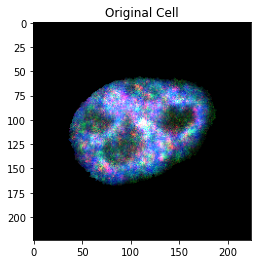

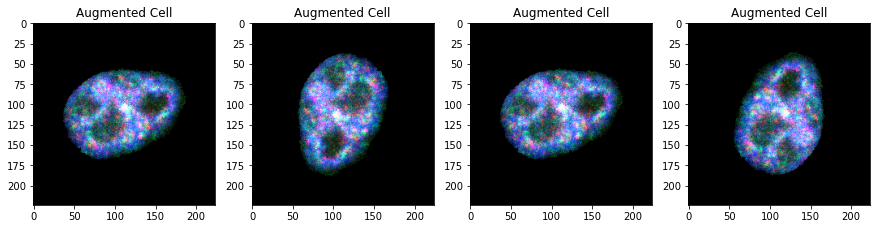

In [17]:
# Visualize the original vs. random flipping and rotations
visualize_cell(image)

In [19]:
model_ResNet50V2 = tf.keras.applications.ResNet50V2(
    include_top=True, 
    weights='imagenet', 
    input_tensor=None, 
    input_shape=None,
    pooling=None, 
    classes=1000, 
    #classifier_activation=None,
    classifier_activation='softmax',
)

In [20]:
model_ResNet50V2.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

## Test the ResNet

In [22]:
del(train_data, val_data, test_data)
del(dataset, metadata)

In [23]:
dataset, metadata = tfds.load(
    name=p['tf_ds_name'], 
    data_dir=p['local_tf_datasets'], 
    # If False, returns a dictionary with all the features
    as_supervised=False, 
    shuffle_files=False,
    with_info=True)

train_data, val_data, test_data = dataset['train'], dataset['validation'], dataset['test']

In [24]:
BATCH_SIZE = p['BATCH_SIZE']
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_data = (
    train_data
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_data = (
    val_data
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_data = (
    test_data
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [31]:
columns = ['y', 'y_hat', 'mapobject_id_cell', 'set']
targets_df = pd.DataFrame(columns=columns)

#dss = [train_data, val_data, test_data]
#ds_names = ['train', 'val', 'test']
dss = [val_data]
ds_names = ['val']

for ds, dsn in zip(dss, ds_names):
    for cells in ds:
        cell_ids = [cell_id.decode() for cell_id in cells['mapobject_id_cell'].numpy()]
        cell_ids = np.asarray(cell_ids).reshape(-1,1)
        Y = cells['target'].numpy()
        cell_imgs, _ = filter_channels(cells['image'], _)
        print(cell_imgs.shape)
        Y_hat = model_ResNet50V2.predict(cell_imgs)
        temp = np.max(Y_hat,axis=1)
        temp_arg = np.argmax(Y_hat,axis=1)
        print(temp)
        print(temp_arg)
        break
        #temp_df = pd.DataFrame(np.concatenate((Y, Y_hat), axis=1), columns=['y', 'y_hat'])
        #temp_df['mapobject_id_cell'] = cell_ids
        #temp_df['set'] = dsn
        #targets_df = pd.concat((targets_df, temp_df), axis=0, ignore_index=True)
#targets_df

(32, 224, 224, 3)
[0.81759936 0.43584847 0.83370614 0.90200543 0.7118228  0.8070534
 0.8392705  0.99503905 0.5883056  0.39181972 0.90947026 0.6791667
 0.939095   0.93234086 0.7384183  0.9046523  0.6870936  0.7728696
 0.955141   0.7260528  0.9669735  0.94513863 0.40814006 0.8448832
 0.6357834  0.81598943 0.8305231  0.8502391  0.92595714 0.6320061
 0.9039046  0.8787129 ]
[971 107 107 107 107 971 107 971 971 948 107 107 111 107 107 107 107 107
 107 111 107 107 971 107 107 107 107 107 107 107 107 111]
